#### Introduction

In this project we'll attempt to make a submission for Kaggle's I’m Something of a Painter Myself Challenge

In [1]:
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
import time

import os
import shutil

### Loading the Data and EDA

In [2]:
in_dir = 'kaggle/input/gan-getting-started'
out_dir = 'kaggle/out'

monet_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/monet_tfrec')
monet_jpg_names = tf.io.gfile.listdir(f'{in_dir}/monet_jpg')
photo_tfrec_names = tf.io.gfile.listdir(f'{in_dir}/photo_tfrec')
photo_jpg_names = tf.io.gfile.listdir(f'{in_dir}/photo_jpg')

print(f'There are {len(monet_tfrec_names)} Monet TFRecord collections')
print(f'There are {len(monet_jpg_names)} Monet jpgs in total')
print(f'There are {len(photo_tfrec_names)} photo TFRecord collections')
print(f'There are {len(photo_jpg_names):,} photo jpgs in total')
print()
print(f'Sample of what the TFRecord files look like: {monet_tfrec_names}')

There are 5 Monet TFRecord collections
There are 300 Monet jpgs in total
There are 20 photo TFRecord collections
There are 7,038 photo jpgs in total

Sample of what the TFRecord files look like: ['monet00-60.tfrec', 'monet16-60.tfrec', 'monet08-60.tfrec', 'monet04-60.tfrec', 'monet12-60.tfrec']


In [3]:
ex = tf.train.Example()
ex.ParseFromString(
    next(iter(tf.data.TFRecordDataset(f'{in_dir}/monet_tfrec/{monet_tfrec_names[0]}').take(1))).numpy()
)
[k for k in ex.features.feature.keys()]

2024-11-18 20:12:55.824695: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144


['target', 'image_name', 'image']

Now let's visualize some images and monets to get a sense of the dataset.

In [4]:
tfrecs_monet = tf.data.TFRecordDataset([f'{in_dir}/monet_tfrec/{f}' for f in monet_tfrec_names])
tfrecs_photo = tf.data.TFRecordDataset([f'{in_dir}/photo_tfrec/{f}' for f in photo_tfrec_names])
    
feature_description = {
    'image_name': tf.io.FixedLenFeature([], tf.string)
    , 'image': tf.io.FixedLenFeature([], tf.string)
    , 'target': tf.io.FixedLenFeature([], tf.string)
    
}

def parse_image(record):
    img = tf.io.parse_single_example(record, feature_description)['image']
    img = tf.io.decode_image(
        img
        , channels=3
    )
    img = tf.cast(img, tf.float32) / 255.0

    return img

parsed_images_monet = tfrecs_monet.map(parse_image)
parsed_images_photo = tfrecs_photo.map(parse_image)

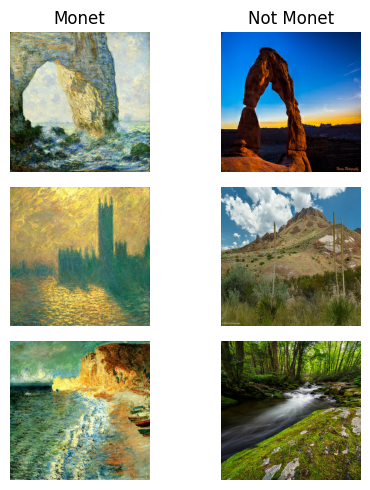

In [5]:
fig, axes = plt.subplots(
    3
    , 2
    , figsize=(5,5)
)

iter_monet = iter(parsed_images_monet)
iter_photo = iter(parsed_images_photo)

axes[0,0].imshow(next(iter_monet))
axes[0,1].imshow(next(iter_photo))
axes[1,0].imshow(next(iter_monet))
axes[1,1].imshow(next(iter_photo))
axes[2,0].imshow(next(iter_monet))
axes[2,1].imshow(next(iter_photo))

axes[0,0].set_title('Monet')
axes[0,1].set_title('Not Monet')

for ax in axes.ravel():
    ax.set_axis_off()

fig.tight_layout()

### Model Architecture

CycleGANs extend the base GAN architecture to perform image translation between two domains (e.g., summer and winter) using unpaired data. They employ two generators and two discriminators to enable bi-directional translation while minimizing cycle consistency loss, which ensures the model preserves the original image's details during forward and backward transformations. Additional loss functions, such as identity loss and adversarial loss, improve the quality of generated images, while PatchGAN discriminators evaluate images at the patch level, enhancing local detail consistency.

CycleGANs can be viewed as adversarial autoencoders, encoding images into a translated style and reconstructing them to maintain original domain features.

In [6]:
def encode(n_filters, filter_size):    
    return models.Sequential([
        layers.Conv2D(
            n_filters
            , filter_size
            , strides=2
            , padding='same'
            , use_bias=False
        )
        , layers.GroupNormalization(groups=-1)
        , layers.LeakyReLU()
    ])

def decode(n_filters, filter_size):
    return models.Sequential([
        layers.Conv2DTranspose(
            n_filters
            , filter_size
            , strides=2
            , padding='same'
            , use_bias=False
        )
        , layers.Dropout(0.5)
        , layers.ReLU()
    ])

In [7]:
print(encode(3, 4)(tf.expand_dims(next(iter_monet), 0)).shape)
print((decode(3, 4)(encode(3,4)(tf.expand_dims(next(iter_monet), 0)))).shape)

(1, 128, 128, 3)
(1, 256, 256, 3)


In [8]:
def construct_generator():
    encoding_stack = [
        encode(64, 4)    
        , encode(128, 4) 
        , encode(256, 4) 
        , encode(512, 4) 
        , encode(512, 4) 
        , encode(512, 4) 
        , encode(512, 4) 
        , encode(512, 4) 
    ]

    decoding_stack = [
        decode(512, 4)   
        , decode(512, 4) 
        , decode(512, 4) 
        , decode(512, 4) 
        , decode(256, 4) 
        , decode(128, 4) 
        , decode(64, 4)  
    ]

    final_decoding_layer = layers.Conv2DTranspose(
        3
        , 4
        , strides=2
        , padding='same'
        , activation='tanh'
    )                    

    inputs = layers.Input((256, 256, 3))

    translated_images = inputs

    
    skips = []
    for endecoder in encoding_stack:
        translated_images = endecoder(translated_images)
        skips.append(translated_images)

    
    skips = reversed(skips[:-1])

    
    for decoder, skip in zip(decoding_stack, skips):
        translated_images = decoder(translated_images)
        translated_images = layers.Concatenate()([translated_images, skip])

    
    translated_images = final_decoding_layer(translated_images)

    return tf.keras.Model(inputs=inputs, outputs=translated_images) 

As you can see, for the generator to work, it needs to encodes and decodes the image.

In [15]:
# visualize the generator

generator = construct_generator()
generator.summary()

Model: "functional_114"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_99      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_93       │ (None, 128, 128,  │      3,200 │ input_layer_99[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_94       │ (None, 64, 64,    │    131,328 │ sequential_93[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_95       │ (None, 32, 32,    │    524,800 │ sequential_94[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_96       │ (None, 16, 16,    │  2,098,176 │ sequential_95[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_97       │ (None, 8, 8, 512) │  4,195,328 │ sequential_96[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_98       │ (None, 4, 4, 512) │  4,195,328 │ sequential_97[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_99       │ (None, 2, 2, 512) │  4,195,328 │ sequential_98[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_100      │ (None, 1, 1, 512) │  4,195,328 │ sequential_99[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_101      │ (None, 2, 2, 512) │  4,194,304 │ sequential_100[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_42      │ (None, 2, 2,      │          0 │ sequential_101[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_99[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_102      │ (None, 4, 4, 512) │  8,388,608 │ concatenate_42[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_43      │ (None, 4, 4,      │          0 │ sequential_102[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_98[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_103      │ (None, 8, 8, 512) │  8,388,608 │ concatenate_43[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_44      │ (None, 8, 8,      │          0 │ sequential_103[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_97[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_104      │ (None, 16, 16,    │  8,388,608 │ concatenate_44[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_45      │ (None, 16, 16,    │          0 │ sequential_104[0

 Total params: 54,410,115 (207.56 MB)

 Trainable params: 54,410,115 (207.56 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
generator_monet_to_photo = construct_generator()
generator_photo_to_monet = construct_generator()

Now, let's construct the discriminator

In [20]:
def construct_discriminator():
    inputs = layers.Input((256, 256, 3))

    out = models.Sequential([
        layers.Input((256, 256, 3))
        , encode(64, 4)          
        , encode(128, 4)         
        , encode(256, 4)         
        , layers.ZeroPadding2D() 
        , layers.Conv2D(
            512
            , 4
            , strides=1
            , use_bias=False
        )                        
        
        , layers.GroupNormalization(groups=-1)
        , layers.LeakyReLU()
        , layers.ZeroPadding2D() 
        , layers.Conv2D(
            1
            , 4
            , strides=1
        )                        
    
    ])(inputs) 

    return tf.keras.Model(inputs=inputs, outputs=out)

In [22]:
discriminator = construct_discriminator()
discriminator.summary()

Model: "functional_215"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_211 (InputLayer)    │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_201 (Sequential)     │ (None, 30, 30, 1)      │     2,765,697 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,697 (10.55 MB)

 Trainable params: 2,765,697 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
discriminator_monet = construct_discriminator()
discriminator_photo = construct_discriminator()

In [25]:
# Lambda controls the magnitude of the effect of the cycle consistency loss.
# A higher lambda means cycle consistency loss plays a larger role in relation
# to adversarial loss. A lower lambda flips that importance.
lambda_param = 10

def generator_loss(generated_image):
    return losses.BinaryCrossentropy(from_logits=True)(
        tf.ones_like(generated_image)
        , generated_image
    )

def discriminator_loss(real_image, generated_image):
    loss_real = losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real_image), real_image)
    loss_generated = losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated_image), generated_image)
    return (loss_real + loss_generated) * 0.5

def cycle_loss(real_image, cycled_image):
    return lambda_param * tf.reduce_mean(tf.abs(tf.cast(real_image, tf.float32) - cycled_image))

def identity_loss(real_image, generated_image):
    return lambda_param * 0.5 * tf.reduce_mean(tf.abs(tf.cast(real_image, tf.float32) - generated_image))

### Model Training

In [28]:
ds_monet = parsed_images_monet.batch(1)
ds_photo = parsed_images_photo.batch(1)

In [34]:
generator_monet_to_photo = construct_generator()
generator_photo_to_monet = construct_generator()

discriminator_monet = construct_discriminator()
discriminator_photo = construct_discriminator()

optimizer_generator_monet_to_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_generator_photo_to_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_discriminator_monet = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
optimizer_discriminator_photo = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)

@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:

        # Generated photo and monet images
        generated_photo = generator_monet_to_photo(real_monet, training=True)
        generated_monet = generator_photo_to_monet(real_photo, training=True)

        # Grab outputs for cycle consistency loss
        cycled_photo = generator_monet_to_photo(generated_monet, training=True)
        cycled_monet = generator_photo_to_monet(generated_photo, training=True)

        # Grab outputs for identity loss
        identity_monet = generator_photo_to_monet(real_monet, training=True)
        identity_photo = generator_monet_to_photo(real_photo, training=True)

        # Identity loss discriminator
        discriminator_real_monet = discriminator_monet(real_monet, training=True)
        discriminator_real_photo = discriminator_photo(real_photo, training=True)

        # Adversarial Loss discriminator
        discriminator_generated_monet = discriminator_monet(generated_monet, training=True)
        discriminator_generated_photo = discriminator_photo(generated_photo, training=True)

        # Adversarial loss
        generator_monet_to_photo_loss = generator_loss(discriminator_generated_photo)
        generator_photo_to_monet_loss = generator_loss(discriminator_generated_monet)

        # Combined cycle consistency loss
        total_cycle_loss = cycle_loss(real_monet, cycled_monet) + cycle_loss(real_photo, cycled_photo)

        # Identity loss
        identity_loss_monet = identity_loss(real_monet, identity_monet)
        identity_loss_photo = identity_loss(real_photo, identity_photo)

        # Total generator loss -- adversarial loss + cycle consistency loss + identity loss
        total_generator_monet_to_photo_loss = generator_monet_to_photo_loss + total_cycle_loss + identity_loss_monet
        total_generator_photo_to_monet_loss = generator_photo_to_monet_loss + total_cycle_loss + identity_loss_photo

        # Discriminator loss -- real loss + generated loss
        discriminator_monet_loss = discriminator_loss(discriminator_real_monet, discriminator_generated_monet)
        discriminator_photo_loss = discriminator_loss(discriminator_real_photo, discriminator_generated_photo)

    # Gradients
    generator_monet_to_photo_gradients = tape.gradient(
        total_generator_monet_to_photo_loss
        , generator_monet_to_photo.trainable_variables
    )
    generator_photo_to_monet_gradients = tape.gradient(
        total_generator_photo_to_monet_loss
        , generator_photo_to_monet.trainable_variables
    )
    discriminator_monet_gradients = tape.gradient(
        discriminator_monet_loss
        , discriminator_monet.trainable_variables
    )
    discriminator_photo_gradients = tape.gradient(
        discriminator_photo_loss
        , discriminator_photo.trainable_variables
    )

    # Optimizers
    optimizer_generator_monet_to_photo.apply_gradients(
        zip(
            generator_monet_to_photo_gradients
            , generator_monet_to_photo.trainable_variables
        )
    )
    optimizer_generator_photo_to_monet.apply_gradients(
        zip(
            generator_photo_to_monet_gradients
            , generator_photo_to_monet.trainable_variables
        )
    )
    optimizer_discriminator_monet.apply_gradients(
        zip(
            discriminator_monet_gradients
            , discriminator_monet.trainable_variables
        )
    )
    optimizer_discriminator_photo.apply_gradients(
        zip(
            discriminator_photo_gradients
            , discriminator_photo.trainable_variables
        )
    )
    

n_epochs = 5 # my computer is slow :(

for epoch in range(n_epochs):
    n=0
    for image_monet, image_photo in tf.data.Dataset.zip((ds_monet, ds_photo)):
        train_step(image_monet, image_photo)
        n += 1
    print("epoch: ", epoch, "completed")

epoch:  0 completed


2024-11-18 21:00:25.011740: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


epoch:  1 completed
epoch:  2 completed
epoch:  3 completed
epoch:  4 completed


In [35]:
def show_images(model, test_input):
    pred = model(test_input)
    
    fig, axes = plt.subplots(
        1
        , 2
        , figsize=(15,15)
    )

    axes[0].imshow(test_input[0].numpy().squeeze())
    axes[1].imshow(pred[0].numpy().squeeze())

    axes[0].set_title('Real Image', fontsize=24)
    axes[1].set_title('Generated Image', fontsize=24)

    # Turn axis labels and grids off
    for ax in axes.ravel():
        ax.set_axis_off()

    fig.tight_layout()
    plt.show()

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_2556. Received: the structure of inputs=['*']
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.093675196..0.96351117].


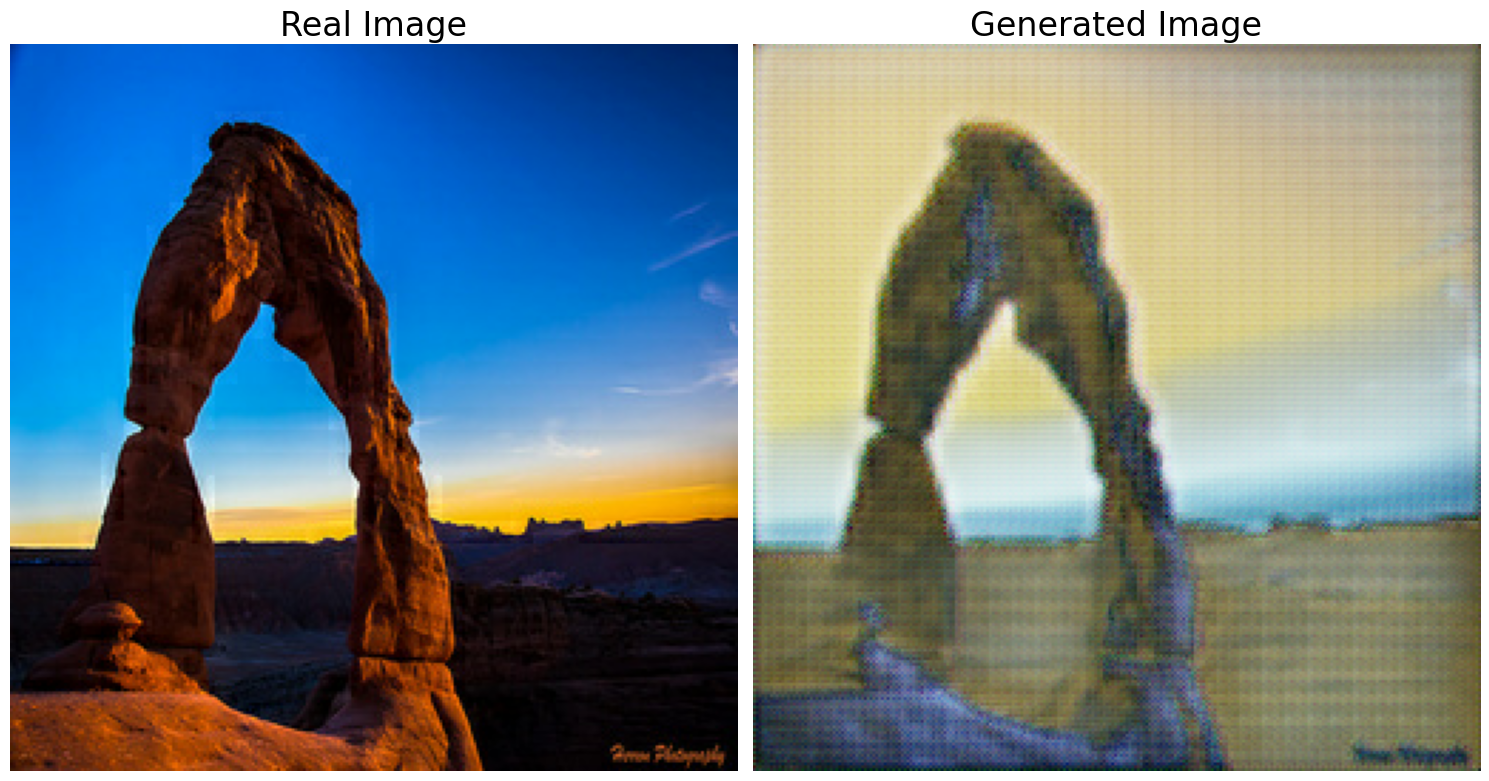

In [36]:
sample_photo = [image for image in ds_photo.take(1)]
show_images(generator_photo_to_monet, sample_photo)


In [37]:
if os.path.exists(f'{out_dir}/imgs'):
    shutil.rmtree(f'{out_dir}/imgs')
os.makedirs(f'{out_dir}/imgs')

n=1
for img in ds_photo:
    pred = (generator_photo_to_monet(img, training=False)[0].numpy().squeeze() * 255).astype(np.uint8)
    tf.keras.utils.save_img(f'{out_dir}/imgs/{n}.jpg', pred)
    n += 1
    
shutil.make_archive(f'{out_dir}/images', 'zip', f'{out_dir}/imgs')
shutil.rmtree(f'{out_dir}/imgs')

os.remove(f'{out_dir}/model.png')

FileNotFoundError: [Errno 2] No such file or directory: 'kaggle/out/model.png'